# F1 Tire Degradation Analysis

This notebook contains clean, production-ready functions for F1 tire degradation analysis using FastF1 data.

## Features:
- **Gap Calculations**: Calculate gaps to car ahead for dirty air analysis
- **Fuel Corrections**: Apply realistic fuel load corrections to lap times
- **Dirty Air Modeling**: Convert gaps to dirty air penalty features
- **Clean Lap Filtering**: Filter to representative laps only
- **Complete Pipeline**: One-function processing from raw session to analysis-ready data

## Usage:
```python
session = fastf1.get_session(2024, "Bahrain", "R")
session.load(telemetry=False, weather=True)
processed_laps = process_race_for_tire_analysis(session)
```

## Imports and Setup

In [28]:
import fastf1
import fastf1.plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("F1 Tire Degradation Analysis Environment Ready! 🏎️")

F1 Tire Degradation Analysis Environment Ready! 🏎️


## Core Functions

These functions provide a complete pipeline for processing F1 race data for tire degradation analysis.

In [29]:
def calculate_gaps_to_car_ahead(laps):
    """
    Calculate gaps to car ahead for each lap based on position and timing data.
    This replicates the gap calculation logic for dirty air analysis.
    
    Parameters:
    - laps: FastF1 laps dataframe (raw session.laps)
    
    Returns:
    - DataFrame with gap columns added: Start_Gap, S1_Gap, S2_Gap, S3_Gap, Avg_Gap
    """
    # Work with a copy to avoid modifying original
    laps_with_gaps = laps.copy()
    
    # Add LapTimeSeconds if not present
    if 'LapTimeSeconds' not in laps_with_gaps.columns:
        laps_with_gaps['LapTimeSeconds'] = laps_with_gaps['LapTime'].dt.total_seconds()
    
    # Get accurate laps for creating the "car ahead" reference
    accurate_laps_for_ahead = laps_with_gaps[laps_with_gaps['IsAccurate'] == True].copy()
    
    # Create car_ahead dataframe with timing data
    car_ahead = accurate_laps_for_ahead[['LapStartTime', 'Position', 'LapNumber', 
                                       'Sector1SessionTime', 'Sector2SessionTime', 
                                       'Sector3SessionTime']].copy()
    
    # Create merge key for car ahead (position + 1 = car we're following)
    car_ahead['MergeKey'] = car_ahead['Position'] + 1
    
    # Rename columns to indicate they're for the car ahead
    car_ahead.rename(columns={
        'LapStartTime': 'Start_Ahead', 
        'Sector1SessionTime': 'S1_Ahead', 
        'Sector2SessionTime': 'S2_Ahead', 
        'Sector3SessionTime': 'S3_Ahead'
    }, inplace=True)
    
    # Merge with main laps data to get car ahead timing
    laps_with_gaps = laps_with_gaps.merge(
        car_ahead, 
        left_on=['Position', 'LapNumber'], 
        right_on=['MergeKey', 'LapNumber'], 
        how='left'
    )
    
    # Calculate gaps in seconds
    laps_with_gaps['Start_Gap'] = (laps_with_gaps['LapStartTime'] - laps_with_gaps['Start_Ahead']).dt.total_seconds()
    laps_with_gaps['S1_Gap'] = (laps_with_gaps['Sector1SessionTime'] - laps_with_gaps['S1_Ahead']).dt.total_seconds()
    laps_with_gaps['S2_Gap'] = (laps_with_gaps['Sector2SessionTime'] - laps_with_gaps['S2_Ahead']).dt.total_seconds()
    laps_with_gaps['S3_Gap'] = (laps_with_gaps['Sector3SessionTime'] - laps_with_gaps['S3_Ahead']).dt.total_seconds()
    
    # Calculate average gap across sectors
    laps_with_gaps['Avg_Gap'] = (laps_with_gaps['S1_Gap'] + laps_with_gaps['S2_Gap'] + laps_with_gaps['S3_Gap']) / 3
    
    # Clean up negative gaps (when we're ahead of the reference car)
    laps_with_gaps.loc[laps_with_gaps['Start_Gap'] < 0, 'Start_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S1_Gap'] < 0, 'S1_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S2_Gap'] < 0, 'S2_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S3_Gap'] < 0, 'S3_Gap'] = np.nan
    
    return laps_with_gaps


def compute_dirty_air_feature(df, gap_col='Start_Gap'):
    """
    Convert gap (seconds) to a dirty-air feature using the Start_Gap column.
    We use a smooth transform: small gaps -> strong dirty-air penalty.
    Returns 'dirty_air' where higher = worse (more lap time lost).
    
    Parameters:
    - df: DataFrame with gap data
    - gap_col: Column name for gap data (default 'Start_Gap')
    
    Returns:
    - DataFrame with 'dirty_air' column added (0-1 scale, 1=worst penalty)
    """
    out = df.copy()
    # Use the Start_Gap column that was calculated earlier, or fall back to provided gap_col
    if 'Start_Gap' in out.columns:
        g = out['Start_Gap'].fillna(999.0)  # No car ahead -> large gap (clean air)
    elif gap_col in out.columns:
        g = out[gap_col].fillna(999.0)
    else:
        raise ValueError(f"Neither 'Start_Gap' nor '{gap_col}' found in dataframe")
    
    # Example transform: inverse gap up to a clamp
    clamp = 5.0   # gaps > clamp treated as "clean air"
    g_clamped = np.minimum(g, clamp)
    # Inverse with smoothness; shift to 0..1
    out['dirty_air'] = 1.0 - (g_clamped / clamp) # 1 = bumper-to-bumper, 0 = >clamp clean
    #out['dirty_air'] = (1.0 - (g_clamped / clamp)) ** 2       Test later power transform for more non-linearity
    return out


def fuel_correct_lap_time(df, total_fuel_load=95, fuel_pace_adjustment=0.03, lap_time_col='LapTimeSeconds'):
    """
    Subtract estimated fuel-related time from lap_time based on race progression.
    Assumes steady fuel burn from total_fuel_load kg to ~5kg at race end.
    
    Parameters:
    - df: DataFrame with lap time data
    - total_fuel_load: Starting fuel load in kg (default 95kg, ending ~5kg = 90kg burned)
    - fuel_pace_adjustment: Time loss per kg of fuel (default 0.03s/kg)
    - lap_time_col: Column name for lap times in seconds
    
    Returns:
    - DataFrame with 'fuel_load', 'fuel_time_loss', and 'lap_time_fuel_corrected' columns
    """
    out = df.copy()
    
    # Calculate fuel load based on lap progression within each driver's stint
    # Group by driver to handle each driver separately
    def calculate_fuel_for_driver(driver_df):
        driver_df = driver_df.copy()
        lap_count = len(driver_df)
        
        # Calculate fuel per lap (90kg burned over race distance)
        fuel_per_lap = total_fuel_load / lap_count if lap_count > 0 else 0
        
        # Fuel load decreases linearly: starts high, ends low
        # Create fuel load based on remaining laps (reverse order)
        remaining_laps = np.arange(lap_count, 0, -1)
        driver_df['fuel_load'] = remaining_laps * fuel_per_lap + 5  # +5kg minimum fuel
        
        return driver_df
    
    # Apply fuel calculation per driver
    if 'Driver' in out.columns:
        out = out.groupby('Driver', group_keys=False).apply(calculate_fuel_for_driver)
    else:
        # If no driver column, treat as single driver
        lap_count = len(out)
        fuel_per_lap = 90 / lap_count if lap_count > 0 else 0
        remaining_laps = np.arange(lap_count, 0, -1)
        out['fuel_load'] = remaining_laps * fuel_per_lap + 5
    
    # Calculate time loss due to fuel weight
    out['fuel_time_loss'] = out['fuel_load'] * fuel_pace_adjustment
    
    # Create fuel-corrected lap time
    if lap_time_col not in out.columns:
        # Try to create LapTimeSeconds if LapTime exists
        if 'LapTime' in out.columns:
            out['LapTimeSeconds'] = out['LapTime'].dt.total_seconds()
        else:
            raise ValueError(f"Column '{lap_time_col}' not found and cannot create it")
    
    out['lap_time_fuel_corrected'] = out[lap_time_col] - out['fuel_time_loss']
    
    return out


def filter_clean_laps(df, is_accurate_col='IsAccurate', min_speed=80.0, speed_col='AverageSpeed'):
    """
    Filter laps to only include "clean" laps for analysis.
    
    Criteria:
    - is_accurate_col == True (excludes outlaps, safety car, etc.)
    - speed_col >= min_speed (if column exists)
    
    Parameters:
    - df: DataFrame with lap data
    - is_accurate_col: Column name for accuracy flag
    - min_speed: Minimum average speed threshold
    - speed_col: Column name for speed data
    
    Returns:
    - Filtered DataFrame with only clean laps
    """
    out = df.copy()
    
    # Always filter by accuracy
    mask = (out[is_accurate_col] == True)
    
    # Add speed filter if column exists
    if speed_col in out.columns:
        mask = mask & (out[speed_col] >= min_speed)
    
    return out[mask]


def process_race_for_tire_analysis(session, include_weather=True):
    """
    Complete pipeline to process a race session for tire degradation analysis.
    Takes raw session and returns clean laps with all corrections applied.
    
    This is the main function that combines all the processing steps.
    
    Parameters:
    - session: FastF1 session object (already loaded with session.load())
    - include_weather: Whether to merge weather data (default True)
    
    Returns:
    - DataFrame ready for tire degradation analysis with columns:
      * lap_time_fuel_corrected: Fuel-corrected lap times
      * dirty_air: Dirty air penalty feature (0-1)
      * fuel_load: Calculated fuel load per lap
      * Start_Gap, S1_Gap, etc.: Gap timing to car ahead
      * Weather data (if available): TrackTemp, AirTemp, etc.
    """
    print("🏎️  Processing race data for tire analysis...")
    
    # Step 1: Get raw laps
    laps = session.laps.copy()
    print(f"📊 Starting with {len(laps)} total laps")
    
    # Step 2: Calculate gaps to car ahead
    print("⏱️  Calculating gaps to car ahead...")
    laps = calculate_gaps_to_car_ahead(laps)
    
    # Step 3: Merge weather data if available and requested
    if include_weather and hasattr(session, 'weather_data') and session.weather_data is not None:
        print("🌡️  Merging weather data...")
        laps = laps.sort_values(by='Time')
        weather_data = session.weather_data.sort_values(by='Time')
        laps = pd.merge_asof(laps, weather_data, left_on='Time', right_on='Time', direction='nearest')
    
    # Step 4: Filter to clean laps only
    print("🧹 Filtering to clean laps...")
    laps = filter_clean_laps(laps)
    print(f"✅ After filtering: {len(laps)} clean laps")
    
    # Step 5: Apply fuel correction
    print("⛽ Applying fuel corrections...")
    laps = fuel_correct_lap_time(laps)
    
    # Step 6: Add dirty air feature
    print("💨 Computing dirty air features...")
    laps = compute_dirty_air_feature(laps)
    
    print("🎉 Processing complete!")
    print(f"📈 Final dataset: {len(laps)} laps from {laps['Driver'].nunique()} drivers")
    
    return laps

print("✅ All functions loaded successfully!")

✅ All functions loaded successfully!


## Usage Examples

Here are examples of how to use the functions for tire degradation analysis.

In [30]:
# Example 1: Complete Pipeline (Recommended)
# This is the easiest way to get analysis-ready data

print("=== EXAMPLE 1: Complete Pipeline ===")
print("Loading 2024 Bahrain Grand Prix...")

session = fastf1.get_session(2024, "Bahrain", "R")
session.load(telemetry=False, weather=True)

# Process the entire race with one function call
processed_laps = process_race_for_tire_analysis(session, include_weather=True)

print("\n📊 Sample of processed data:")
display_cols = ['Driver', 'LapNumber', 'LapTimeSeconds', 'lap_time_fuel_corrected', 
               'fuel_load', 'Start_Gap', 'dirty_air']
print(processed_laps[display_cols].head(10))

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


=== EXAMPLE 1: Complete Pipeline ===
Loading 2024 Bahrain Grand Prix...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


🏎️  Processing race data for tire analysis...
📊 Starting with 1129 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1024 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1024 laps from 20 drivers

📊 Sample of processed data:
   Driver  LapNumber  LapTimeSeconds  lap_time_fuel_corrected  fuel_load  \
20    VER        2.0          96.296                   93.296      100.0   
21    LEC        2.0          96.862                   93.862      100.0   
22    RUS        2.0          96.635                   93.635      100.0   
23    PER        2.0          96.541                   93.541      100.0   
24    SAI        2.0          97.236                   94.236      100.0   
25    ALO        2.0          98.020                   95.020      100.0   
26    NOR        2.0          98.010                   95.010      100.0   
27    PIA        2.0     

In [31]:
processed_laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position_x', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'LapTimeSeconds', 'Start_Ahead',
       'Position_y', 'S1_Ahead', 'S2_Ahead', 'S3_Ahead', 'MergeKey',
       'Start_Gap', 'S1_Gap', 'S2_Gap', 'S3_Gap', 'Avg_Gap', 'AirTemp',
       'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection',
       'WindSpeed', 'fuel_load', 'fuel_time_loss', 'lap_time_fuel_corrected',
       'dirty_air'],
      dtype='object')

In [32]:
# Example 2: Step-by-step usage (for customization)
print("=== EXAMPLE 2: Step-by-step Processing ===")

# Start with raw laps
raw_laps = session.laps.copy()
print(f"Raw laps: {len(raw_laps)}")

# Step 1: Calculate gaps
laps_with_gaps = calculate_gaps_to_car_ahead(raw_laps)
print(f"Gaps calculated for {len(laps_with_gaps)} laps")

# Step 2: Filter clean laps
clean_laps = filter_clean_laps(laps_with_gaps)
print(f"Clean laps: {len(clean_laps)}")

# Step 3: Apply fuel correction
fuel_corrected = fuel_correct_lap_time(clean_laps)
print(f"Fuel correction applied")

# Step 4: Add dirty air feature
final_data = compute_dirty_air_feature(fuel_corrected)
print(f"Dirty air features added")

print("\n✅ Step-by-step processing complete!")

=== EXAMPLE 2: Step-by-step Processing ===
Raw laps: 1129
Gaps calculated for 1129 laps
Clean laps: 1024
Fuel correction applied
Dirty air features added

✅ Step-by-step processing complete!


In [33]:
# Example 3: Analyze specific driver
print("=== EXAMPLE 3: Single Driver Analysis ===")

# Focus on Verstappen's data
verstappen_data = processed_laps[processed_laps['Driver'] == 'VER'].copy()

print(f"Verstappen: {len(verstappen_data)} clean laps")
print("\nFuel load progression:")
print(verstappen_data[['LapNumber', 'fuel_load', 'fuel_time_loss', 'lap_time_fuel_corrected']].head(10))

print("\nDirty air situations (gaps < 2 seconds):")
dirty_air_laps = verstappen_data[verstappen_data['Start_Gap'] < 2.0]
if len(dirty_air_laps) > 0:
    print(dirty_air_laps[['LapNumber', 'Start_Gap', 'dirty_air', 'LapTimeSeconds']].head())
else:
    print("No significant dirty air situations found")

=== EXAMPLE 3: Single Driver Analysis ===
Verstappen: 52 clean laps

Fuel load progression:
     LapNumber   fuel_load  fuel_time_loss  lap_time_fuel_corrected
20         2.0  100.000000        3.000000                93.296000
40         3.0   98.173077        2.945192                93.807808
60         4.0   96.346154        2.890385                93.756615
80         5.0   94.519231        2.835577                94.337423
100        6.0   92.692308        2.780769                94.311231
120        7.0   90.865385        2.725962                94.312038
140        8.0   89.038462        2.671154                94.352846
160        9.0   87.211538        2.616346                94.612654
180       10.0   85.384615        2.561538                94.398462
200       11.0   83.557692        2.506731                94.578269

Dirty air situations (gaps < 2 seconds):
No significant dirty air situations found


## Data Visualization Examples

Quick visualizations to understand the processed data.

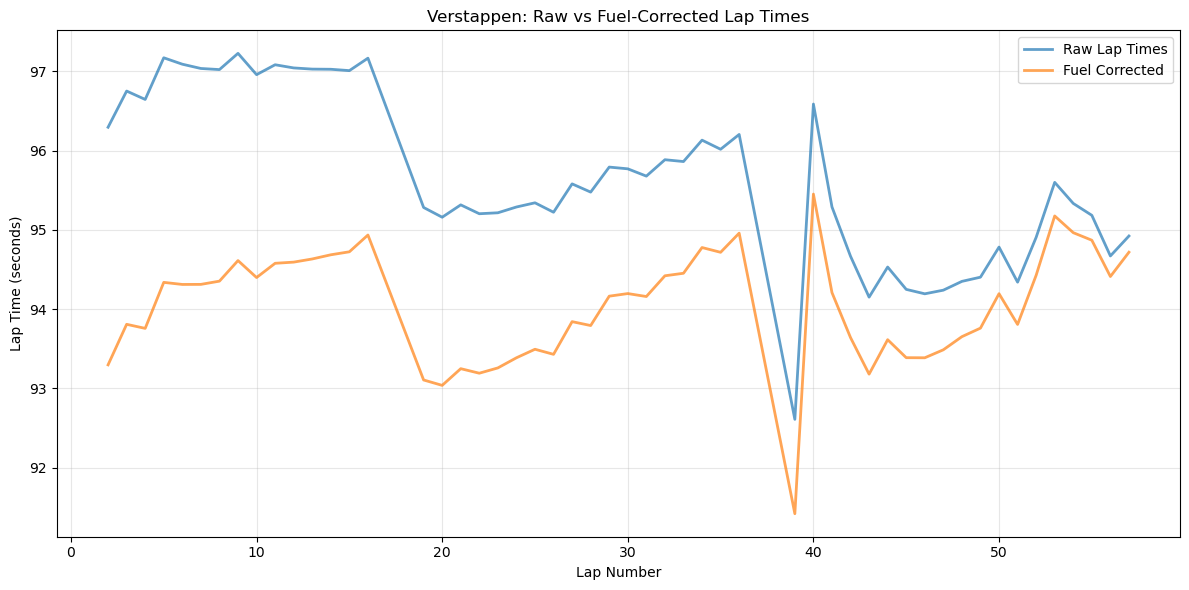

Average fuel correction: 1.602 seconds


In [34]:
# Visualization 1: Fuel-corrected vs Raw lap times
plt.figure(figsize=(12, 6))

# Plot for a specific driver
driver_data = processed_laps[processed_laps['Driver'] == 'VER'].copy()

plt.plot(driver_data['LapNumber'], driver_data['LapTimeSeconds'], 
         label='Raw Lap Times', alpha=0.7, linewidth=2)
plt.plot(driver_data['LapNumber'], driver_data['lap_time_fuel_corrected'], 
         label='Fuel Corrected', alpha=0.7, linewidth=2)

plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.title('Verstappen: Raw vs Fuel-Corrected Lap Times')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average fuel correction: {driver_data['fuel_time_loss'].mean():.3f} seconds")

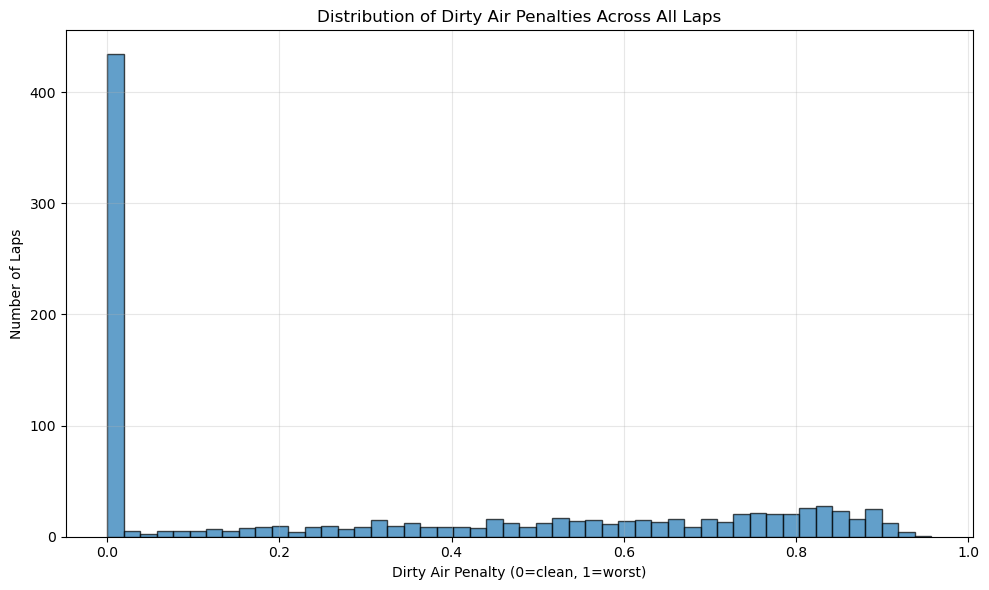

Clean air laps (penalty < 0.2): 47.8%


In [35]:
# Visualization 2: Dirty air distribution
plt.figure(figsize=(10, 6))

# Plot dirty air distribution across all drivers
dirty_air_data = processed_laps['dirty_air'].dropna()

plt.hist(dirty_air_data, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Dirty Air Penalty (0=clean, 1=worst)')
plt.ylabel('Number of Laps')
plt.title('Distribution of Dirty Air Penalties Across All Laps')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

clean_air_pct = (dirty_air_data < 0.2).mean() * 100
print(f"Clean air laps (penalty < 0.2): {clean_air_pct:.1f}%")

## Summary

This notebook provides a complete toolkit for F1 tire degradation analysis:

### Key Functions:
1. **`process_race_for_tire_analysis()`** - Main function for complete processing
2. **`calculate_gaps_to_car_ahead()`** - Calculate timing gaps for dirty air analysis  
3. **`fuel_correct_lap_time()`** - Apply realistic fuel load corrections
4. **`compute_dirty_air_feature()`** - Convert gaps to dirty air penalties
5. **`filter_clean_laps()`** - Filter to representative laps only

### Output Data Columns:
- `lap_time_fuel_corrected` - Fuel-corrected lap times
- `dirty_air` - Dirty air penalty (0-1 scale)
- `fuel_load` - Calculated fuel load per lap
- `Start_Gap`, `S1_Gap`, etc. - Timing gaps to car ahead
- Weather data (if available)

### Next Steps:
Use the processed data for:
- Tire degradation modeling
- Performance analysis
- Strategy optimization
- Driver comparisons

---
*Happy analyzing! 🏎️📊*

In [47]:
def merge_circuit_data(processed_laps, circuit_data_csv_path, year=2024):
    """
    Merge circuit-specific data (tire compounds, track characteristics) with processed lap data.
    
    This function combines FastF1 race data with external circuit information to add:
    - Exact tire compound specifications (C1-C5 instead of SOFT/MEDIUM/HARD)
    - Circuit characteristics (length, traction, grip, etc.)
    
    Parameters:
    - processed_laps: DataFrame from process_race_for_tire_analysis()
    - circuit_data_csv_path: Path to CSV file with circuit data
    - year: Year to filter circuit data (default 2024)
    
    Returns:
    - DataFrame with circuit data merged for each lap
    """
    print(f"🔗 Merging circuit data from {circuit_data_csv_path}...")
    
    # Load circuit data
    try:
        circuit_data = pd.read_csv(circuit_data_csv_path)
        print(f"📊 Loaded circuit data: {len(circuit_data)} circuits")
    except FileNotFoundError:
        print(f"❌ Circuit data file not found: {circuit_data_csv_path}")
        return processed_laps
    
    # Filter to specified year
    if 'year' in circuit_data.columns:
        circuit_data = circuit_data[circuit_data['year'] == year]
        print(f"📅 Filtered to {year}: {len(circuit_data)} circuits")
    
    # Create a copy to work with
    laps_with_circuits = processed_laps.copy()
    
    # Get unique race events from processed laps
    if 'EventName' in laps_with_circuits.columns:
        race_events = laps_with_circuits['EventName'].unique()
        print(f"🏁 Races in processed data: {list(race_events)}")
    else:
        print("⚠️ No 'EventName' column found in processed laps")
        return processed_laps
    
    # Create mapping dictionary for race name matching
    # Common variations between FastF1 and manual naming
    race_name_mapping = {
        # FastF1 EventName -> Circuit CSV race_name variations
        'Bahrain Grand Prix': ['bahrain', 'gulf air bahrain', 'formula 1 gulf air bahrain grand prix'],
        'Saudi Arabian Grand Prix': ['saudi', 'arabia', 'jeddah', 'saudi arabian'],
        'Australian Grand Prix': ['australia', 'australian', 'melbourne'],
        'Japanese Grand Prix': ['japan', 'japanese', 'suzuka'],
        'Chinese Grand Prix': ['china', 'chinese', 'shanghai'],
        'Miami Grand Prix': ['miami', 'formula 1 crypto.com miami'],
        'Emilia Romagna Grand Prix': ['imola', 'emilia romagna', 'san marino'],
        'Monaco Grand Prix': ['monaco', 'monte carlo'],
        'Canadian Grand Prix': ['canada', 'canadian', 'montreal'],
        'Spanish Grand Prix': ['spain', 'spanish', 'catalunya', 'barcelona'],
        'Austrian Grand Prix': ['austria', 'austrian', 'red bull ring', 'spielberg'],
        'British Grand Prix': ['britain', 'british', 'silverstone', 'great britain'],
        'Hungarian Grand Prix': ['hungary', 'hungarian', 'hungaroring'],
        'Belgian Grand Prix': ['belgium', 'belgian', 'spa'],
        'Dutch Grand Prix': ['netherlands', 'dutch', 'zandvoort'],
        'Italian Grand Prix': ['italy', 'italian', 'monza'],
        'Azerbaijan Grand Prix': ['azerbaijan', 'baku'],
        'Singapore Grand Prix': ['singapore', 'marina bay'],
        'United States Grand Prix': ['usa', 'united states', 'austin', 'cota'],
        'Mexico City Grand Prix': ['mexico', 'mexican', 'mexico city'],
        'São Paulo Grand Prix': ['brazil', 'brazilian', 'sao paulo', 'interlagos'],
        'Las Vegas Grand Prix': ['vegas', 'las vegas'],
        'Qatar Grand Prix': ['qatar', 'losail'],
        'Abu Dhabi Grand Prix': ['abu dhabi', 'yas marina']
    }
    
    def find_matching_circuit(event_name, circuit_df):
        """Find matching circuit data for a given FastF1 event name."""
        event_lower = event_name.lower()
        
        # Direct match attempts
        for _, circuit_row in circuit_df.iterrows():
            race_name = str(circuit_row.get('Circuit', '')).lower()
            
            # Try exact match first
            if event_lower == race_name:
                return circuit_row
            
            # Try partial matches using mapping
            if event_name in race_name_mapping:
                for variation in race_name_mapping[event_name]:
                    if variation in race_name:
                        return circuit_row
            
            # Try reverse - check if any keyword from race_name is in event_name
            race_keywords = race_name.replace('-', ' ').split()
            for keyword in race_keywords:
                if len(keyword) > 3 and keyword in event_lower:  # Avoid short words
                    return circuit_row
        
        return None
    
    # Track successful and failed matches
    successful_matches = 0
    failed_matches = []
    
    # Process each race event
    for event_name in race_events:
        print(f"\n🔍 Processing: {event_name}")
        
        # Find matching circuit data
        matching_circuit = find_matching_circuit(event_name, circuit_data)
        
        if matching_circuit is not None:
            # Get laps for this event
            event_mask = laps_with_circuits['EventName'] == event_name
            
            # Add circuit data to all laps for this event
            for col in circuit_data.columns:
                if col not in ['EventName', 'year', 'url']:  # Skip metadata columns
                    laps_with_circuits.loc[event_mask, f'{col}'] = matching_circuit[col]
            
            # Map tire compounds to exact compounds
            # Get the compound mapping for this circuit
            soft_compound = matching_circuit.get('Soft')
            medium_compound = matching_circuit.get('Medium') 
            hard_compound = matching_circuit.get('Hard')
            
            # Create exact compound column based on tire type
            def map_compound(row):
                compound_type = row.get('Compound', '').upper()
                if compound_type == 'SOFT':
                    return soft_compound
                elif compound_type == 'MEDIUM':
                    return medium_compound
                elif compound_type == 'HARD':
                    return hard_compound
                else:
                    return compound_type  # Keep original if not standard compound
            
            # Apply compound mapping to this event's laps
            event_laps = laps_with_circuits[event_mask]
            if 'Compound' in event_laps.columns:
                laps_with_circuits.loc[event_mask, 'exact_compound'] = event_laps.apply(map_compound, axis=1)
            
            successful_matches += 1
            print(f"✅ Matched with circuit data")
            print(f"   Compounds: Soft={soft_compound}, Medium={medium_compound}, Hard={hard_compound}")
            
        else:
            failed_matches.append(event_name)
            print(f"❌ No matching circuit data found")
    
    # Summary
    print(f"\n📈 Merge Summary:")
    print(f"   ✅ Successful matches: {successful_matches}")
    print(f"   ❌ Failed matches: {len(failed_matches)}")
    
    if failed_matches:
        print(f"   Failed events: {failed_matches}")
        print(f"   💡 You may need to manually adjust race names in CSV")
    
    # Show available circuit columns
    circuit_cols = [col for col in laps_with_circuits.columns if col.startswith('circuit_')]
    if circuit_cols:
        print(f"   📊 Added circuit columns: {len(circuit_cols)}")
        print(f"   {circuit_cols[:5]}..." if len(circuit_cols) > 5 else f"   {circuit_cols}")
    
    return laps_with_circuits


print("✅ Circuit data merge function added!")

✅ Circuit data merge function added!


In [37]:
def fetch_and_process_race(year, race_identifier, session_type="R", include_weather=True):
    """
    Fetch a single race session, add event name to the data, and process for tire analysis.
    
    This function solves the problem that FastF1 session data doesn't include the event name
    as a column, which is needed for merging with circuit data.
    
    Parameters:
    - year: Year of the race (e.g., 2024)
    - race_identifier: Race identifier (e.g., "Bahrain", "Monaco", 1, 2, etc.)
    - session_type: Session type ("R" for race, "Q" for qualifying, etc.)
    - include_weather: Whether to include weather data
    
    Returns:
    - DataFrame with processed lap data including 'EventName' column
    """
    print(f"🏎️ Fetching {year} {race_identifier} {session_type}...")
    
    try:
        # Get session
        session = fastf1.get_session(year, race_identifier, session_type)
        session.load(telemetry=False, weather=include_weather)
        
        # Get the actual event name from the session
        event_name = session.event.EventName
        print(f"📅 Event name: {event_name}")
        
        # Process the race data
        processed_laps = process_race_for_tire_analysis(session, include_weather=include_weather)
        
        # Add event name to every lap
        processed_laps['EventName'] = event_name
        
        print(f"✅ Processed {len(processed_laps)} laps for {event_name}")
        return processed_laps
        
    except Exception as e:
        print(f"❌ Error processing {year} {race_identifier}: {str(e)}")
        return pd.DataFrame()  # Return empty DataFrame on error


def fetch_multiple_races(race_list, year=2024, session_type="R", include_weather=True):
    """
    Fetch and process multiple races, combining them into a single dataset.
    
    This is the main function for building multi-race datasets with event names.
    
    Parameters:
    - race_list: List of race identifiers (e.g., ["Bahrain", "Saudi Arabia", "Australia"])
    - year: Year of the races (default 2024)
    - session_type: Session type (default "R" for race)
    - include_weather: Whether to include weather data
    
    Returns:
    - Combined DataFrame with all races and EventName column for merging
    """
    print(f"🚀 Fetching {len(race_list)} races from {year}...")
    
    all_races_data = []
    successful_races = []
    failed_races = []
    
    for race_identifier in race_list:
        race_data = fetch_and_process_race(
            year=year, 
            race_identifier=race_identifier, 
            session_type=session_type,
            include_weather=include_weather
        )
        
        if not race_data.empty:
            all_races_data.append(race_data)
            successful_races.append(race_identifier)
        else:
            failed_races.append(race_identifier)
        
        print()  # Add spacing between races
    
    if all_races_data:
        # Combine all race data
        combined_data = pd.concat(all_races_data, ignore_index=True)
        
        print(f"🎉 Successfully combined data!")
        print(f"   ✅ Successful races: {len(successful_races)}")
        print(f"   ❌ Failed races: {len(failed_races)}")
        print(f"   📊 Total laps: {len(combined_data)}")
        print(f"   🏁 Events: {combined_data['EventName'].unique()}")
        
        if failed_races:
            print(f"   ⚠️ Failed races: {failed_races}")
        
        return combined_data
    else:
        print("❌ No races were successfully processed")
        return pd.DataFrame()


print("✅ Race fetching functions added!")


✅ Race fetching functions added!


In [38]:
# After processing race data normally
processed_laps = process_race_for_tire_analysis(session)

# Merge with your circuit data
laps_with_circuits = merge_circuit_data(
    processed_laps, 
    'circuit.csv',  # Your CSV file path
    year=2024
)

# Now you have exact compounds and circuit characteristics!
print(laps_with_circuits.columns)

🏎️  Processing race data for tire analysis...
📊 Starting with 1129 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1024 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1024 laps from 20 drivers
🔗 Merging circuit data from circuit.csv...
📊 Loaded circuit data: 48 circuits
⚠️ No 'EventName' column found in processed laps
Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position_x', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'LapTimeSeconds', 'Start_Ahead',
       'Position_y'

In [39]:
# Example usage: Build a comprehensive 2024 F1 dataset with circuit data

# 2024 F1 race list (you can modify this as needed)
races_2024 = [
    "Bahrain", "Saudi Arabia", "Australia", "Japan", "China",
    "Miami", "Emilia Romagna", "Monaco", "Canada", "Spain",
    "Austria", "Great Britain", "Hungary", "Belgium", "Netherlands",
    "Italy", "Azerbaijan", "Singapore", "United States", "Mexico",
    "Brazil", "Las Vegas", "Qatar", "Abu Dhabi"
]

# Fetch first few races for testing (uncomment to run full season)
test_races = races_2024[:3]  # First 3 races for testing

print("🏎️ Example: Fetching test races...")
# test_data = fetch_multiple_races(test_races, year=2024)

print("""
📋 Usage Examples:

1. Fetch specific races:
   races_to_fetch = ["Monaco", "Silverstone", "Spa"]
   race_data = fetch_multiple_races(races_to_fetch, year=2024)

2. Fetch full 2024 season:
   full_season_data = fetch_multiple_races(races_2024, year=2024)

3. Merge with circuit data:
   circuit_df = pd.read_csv('f1_2024_circuit_tire_data.csv')
   combined_data = merge_circuit_data(race_data, circuit_df)

4. Save for later use:
   race_data.to_csv('f1_2024_race_data.csv', index=False)
   combined_data.to_csv('f1_2024_combined_data.csv', index=False)
""")

🏎️ Example: Fetching test races...

📋 Usage Examples:

1. Fetch specific races:
   races_to_fetch = ["Monaco", "Silverstone", "Spa"]
   race_data = fetch_multiple_races(races_to_fetch, year=2024)

2. Fetch full 2024 season:
   full_season_data = fetch_multiple_races(races_2024, year=2024)

3. Merge with circuit data:
   circuit_df = pd.read_csv('f1_2024_circuit_tire_data.csv')
   combined_data = merge_circuit_data(race_data, circuit_df)

4. Save for later use:
   race_data.to_csv('f1_2024_race_data.csv', index=False)
   combined_data.to_csv('f1_2024_combined_data.csv', index=False)



In [48]:
test_races = ["Bahrain", "Saudi Arabia", "Australia"]
test_data = fetch_multiple_races(test_races, year=2024)
combined_data = merge_circuit_data(test_data, 'circuit.csv', year=2024)
combined_data.columns

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


🚀 Fetching 3 races from 2024...
🏎️ Fetching 2024 Bahrain R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO

📅 Event name: Bahrain Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 1129 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1024 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1024 laps from 20 drivers
✅ Processed 1024 laps for Bahrain Grand Prix

🏎️ Fetching 2024 Saudi Arabia R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Usin

📅 Event name: Saudi Arabian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 901 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 816 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 816 laps from 19 drivers
✅ Processed 816 laps for Saudi Arabian Grand Prix

🏎️ Fetching 2024 Australia R...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


📅 Event name: Australian Grand Prix
🏎️  Processing race data for tire analysis...
📊 Starting with 998 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 857 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 857 laps from 19 drivers
✅ Processed 857 laps for Australian Grand Prix

🎉 Successfully combined data!
   ✅ Successful races: 3
   ❌ Failed races: 0
   📊 Total laps: 2697
   🏁 Events: ['Bahrain Grand Prix' 'Saudi Arabian Grand Prix' 'Australian Grand Prix']
🔗 Merging circuit data from circuit.csv...
📊 Loaded circuit data: 48 circuits
🏁 Races in processed data: ['Bahrain Grand Prix', 'Saudi Arabian Grand Prix', 'Australian Grand Prix']

🔍 Processing: Bahrain Grand Prix
✅ Matched with circuit data
   Compounds: Soft=C3, Medium=C2, Hard=C1

🔍 Processing: Saudi Arabian Grand Prix
✅ Matched with circuit data
   Compounds: Soft=C4, Medium=C3, Hard=C2



Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position_x', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'LapTimeSeconds', 'Start_Ahead',
       'Position_y', 'S1_Ahead', 'S2_Ahead', 'S3_Ahead', 'MergeKey',
       'Start_Gap', 'S1_Gap', 'S2_Gap', 'S3_Gap', 'Avg_Gap', 'AirTemp',
       'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection',
       'WindSpeed', 'fuel_load', 'fuel_time_loss', 'lap_time_fuel_corrected',
       'dirty_air', 'EventName', 'Circuit', 'Year', 'Laps', 'Lap Length',
       'Soft', 'Medium', 'Hard', 'Traction', 'Tyre Stress', 'Asphalt Grip',
       'Asphalt Abrasion', 'Track Evolutio

In [50]:
combined_data[['Compound', 'Soft', 'Medium', 'Hard', 'exact_compound']]

,Compound,Soft,Medium,Hard,exact_compound
0,SOFT,C3,C2,C1,C3
1,SOFT,C3,C2,C1,C3
2,SOFT,C3,C2,C1,C3
3,SOFT,C3,C2,C1,C3
4,SOFT,C3,C2,C1,C3
...,...,...,...,...,...
2692,HARD,C5,C4,C3,C3
2693,HARD,C5,C4,C3,C3
2694,HARD,C5,C4,C3,C3
2695,HARD,C5,C4,C3,C3
